In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import ttest_ind, levene, ks_2samp, shapiro, bartlett, f_oneway, kruskal
from statsmodels.stats.multitest import multipletests

Length of dfs before any filtering: df_wv1 = 36925, df_wv2 = 37000.
Length of dfs after filtering on 0 < mean_sigma0 < 1: 36868, 36949.
Length of dfs after filtering on 0 < mean_psd_band0 < 1e6: 35857, 36949.
Length of dfs after filtering on 0 < mean_psd_band1 < 4000: 33638, 36941.
Length of dfs after filtering on 0 < mean_psd_band2 < 2000: 30187, 36941.


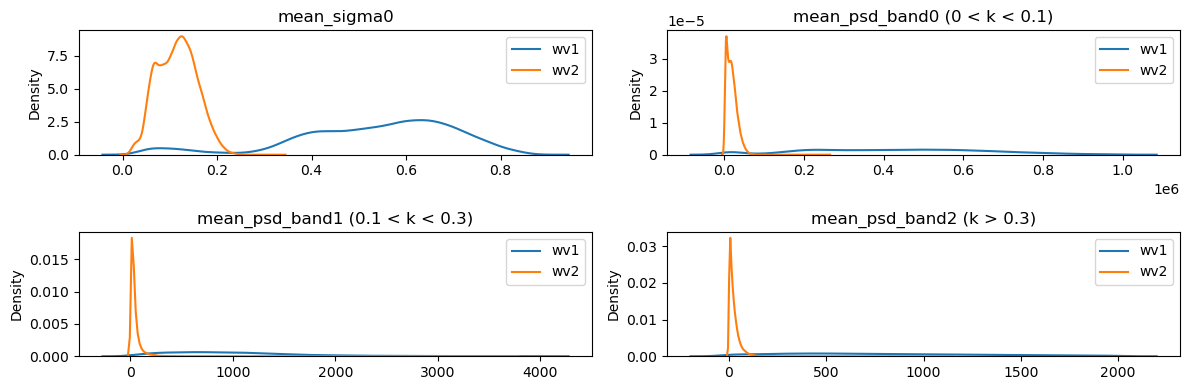

In [8]:
# read parquet

df_wv1 = pd.read_parquet('processed_data/wv1_unstable_gt15.parquet')
df_wv2 = pd.read_parquet('processed_data/wv2_unstable_gt15.parquet')

print(f"Length of dfs before any filtering: df_wv1 = {len(df_wv1)}, df_wv2 = {len(df_wv2)}.")

# Filter data
df_wv1 = df_wv1[(df_wv1.mean_sigma0 > 0) & (df_wv1.mean_sigma0 < 1)]
df_wv2 = df_wv2[(df_wv2.mean_sigma0 > 0) & (df_wv2.mean_sigma0 < 1)]

print(f"Length of dfs after filtering on 0 < mean_sigma0 < 1: {len(df_wv1)}, {len(df_wv2)}.")

df_wv1 = df_wv1[(df_wv1.mean_psd_band0 > 0) & (df_wv1.mean_psd_band0 < 1e6)]
df_wv2 = df_wv2[(df_wv2.mean_psd_band0 > 0) & (df_wv2.mean_psd_band0 < 1e6)]

print(f"Length of dfs after filtering on 0 < mean_psd_band0 < 1e6: {len(df_wv1)}, {len(df_wv2)}.")

df_wv1 = df_wv1[(df_wv1.mean_psd_band1 > 0) & (df_wv1.mean_psd_band1 < 4000)]
df_wv2 = df_wv2[(df_wv2.mean_psd_band1 > 0) & (df_wv2.mean_psd_band1 < 4000)]

print(f"Length of dfs after filtering on 0 < mean_psd_band1 < 4000: {len(df_wv1)}, {len(df_wv2)}.")

df_wv1 = df_wv1[(df_wv1.mean_psd_band2 > 0) & (df_wv1.mean_psd_band2 < 2000)]
df_wv2 = df_wv2[(df_wv2.mean_psd_band2 > 0) & (df_wv2.mean_psd_band2 < 2000)]

print(f"Length of dfs after filtering on 0 < mean_psd_band2 < 2000: {len(df_wv1)}, {len(df_wv2)}.")

# Create figure and subplots
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 4))

# First subplot - mean_sigma0
sns.kdeplot(data=df_wv1.mean_sigma0.values, label="wv1", ax=ax1)
sns.kdeplot(data=df_wv2.mean_sigma0.values, label="wv2", ax=ax1)
ax1.set_title('mean_sigma0')
ax1.legend()

# Second subplot - mean_psd_band0
sns.kdeplot(data=df_wv1.mean_psd_band0.values, label="wv1", ax=ax2)
sns.kdeplot(data=df_wv2.mean_psd_band0.values, label="wv2", ax=ax2)
ax2.set_title('mean_psd_band0 (0 < k < 0.1)')
ax2.legend()

# Third subplot - mean_psd_band1
sns.kdeplot(data=df_wv1.mean_psd_band1.values, label="wv1", ax=ax3)
sns.kdeplot(data=df_wv2.mean_psd_band1.values, label="wv2", ax=ax3)
ax3.set_title('mean_psd_band1 (0.1 < k < 0.3)')
ax3.legend()

# Fourth subplot - mean_psd_band2
sns.kdeplot(data=df_wv1.mean_psd_band2.values, label="wv1", ax=ax4)
sns.kdeplot(data=df_wv2.mean_psd_band2.values, label="wv2", ax=ax4)
ax4.set_title('mean_psd_band2 (k > 0.3)')
ax4.legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

Computing bootstrap confidence intervals...

Bootstrap Confidence Intervals (WV1):

mean_psd_band0:
  mean: [427763.872933, 433969.256045]
  variance: [48472829254.411186, 49991674849.306137]
  skewness: [0.035635, 0.078893]

mean_psd_band1:
  mean: [1030.072324, 1051.083821]
  variance: [513729.544651, 543524.527710]
  skewness: [1.203041, 1.279695]

mean_psd_band2:
  mean: [792.857233, 808.584827]
  variance: [263786.222801, 272568.618906]
  skewness: [0.398810, 0.438984]

Bootstrap Confidence Intervals (WV2):

mean_psd_band0:
  mean: [19259.497501, 19583.225980]
  variance: [159710527.870619, 173372010.474066]
  skewness: [0.850186, 1.820312]

mean_psd_band1:
  mean: [42.712973, 44.671096]
  variance: [3320.145510, 7390.258054]
  skewness: [8.915436, 24.744290]

mean_psd_band2:
  mean: [25.088450, 25.830654]
  variance: [630.062890, 913.979377]
  skewness: [2.676951, 11.898237]

Testing for scale dependence between bands...

Scale Dependence Tests (WV1):

Comparing mean_psd_band0 vs

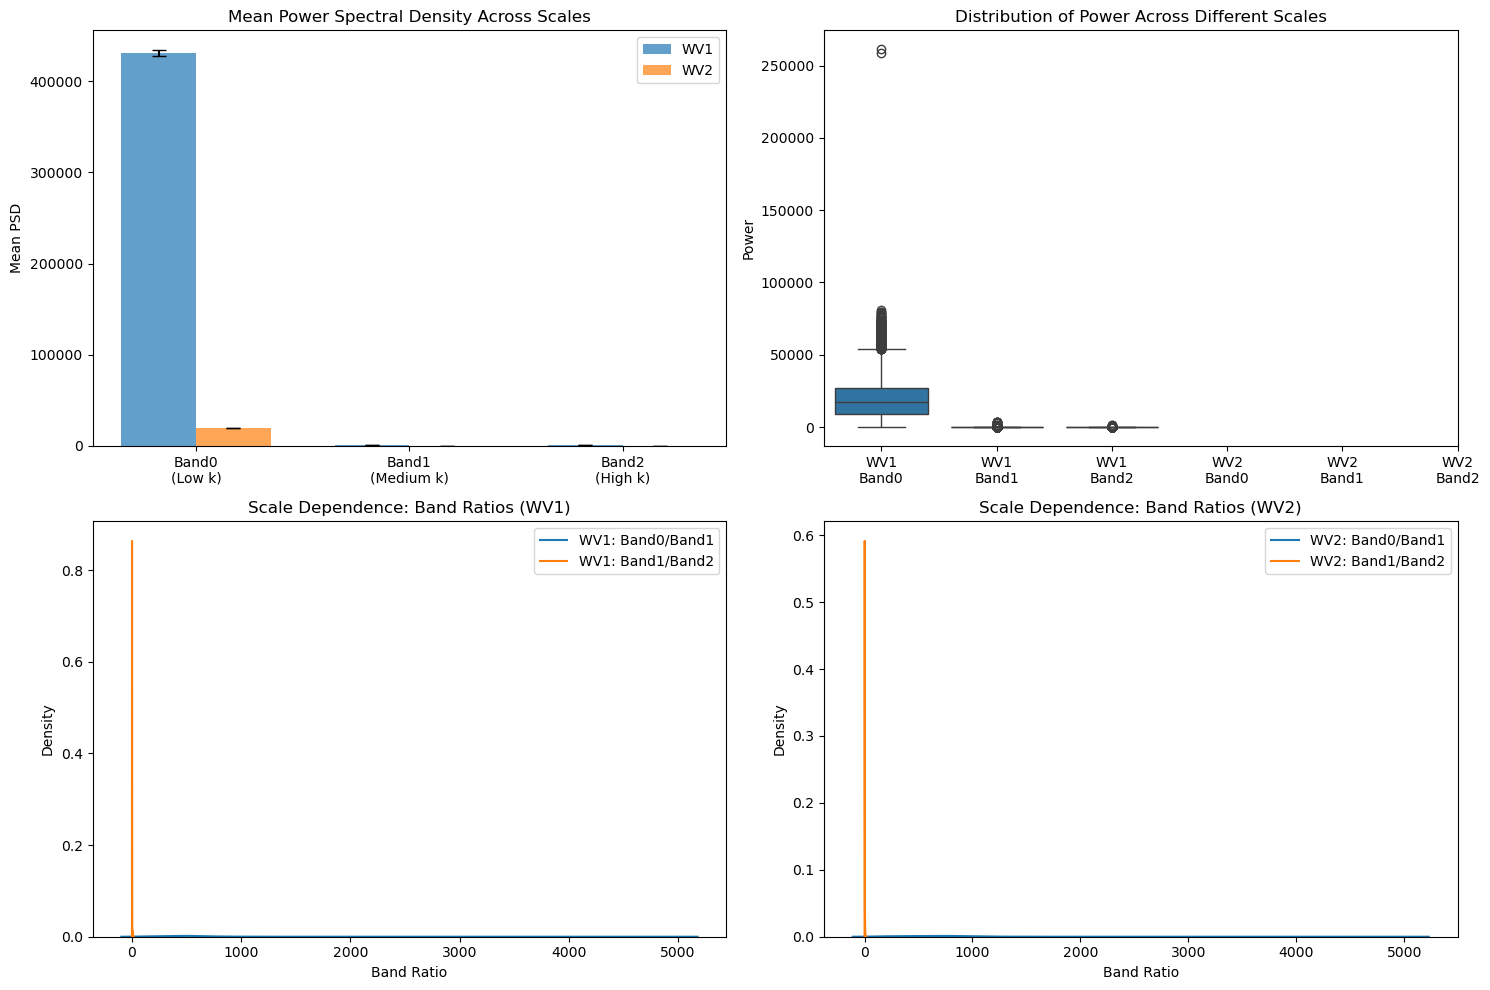

In [9]:
def bootstrap_confidence_intervals(data, n_bootstrap=1000, confidence=0.99):
    """
    Calculate bootstrap confidence intervals for the mean, variance, and skewness
    
    Parameters:
    -----------
    data : array-like
        Data to bootstrap
    n_bootstrap : int
        Number of bootstrap samples
    confidence : float
        Confidence level (between 0 and 1)
    
    Returns:
    --------
    dict
        Dictionary with confidence intervals for each statistic
    """
    bootstrap_means = []
    bootstrap_vars = []
    bootstrap_skews = []
    
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstrap_means.append(np.mean(sample))
        bootstrap_vars.append(np.var(sample))
        bootstrap_skews.append(stats.skew(sample))
    
    lower_quantile = (1 - confidence) / 2
    upper_quantile = 1 - lower_quantile
    
    return {
        'mean': (np.quantile(bootstrap_means, lower_quantile), 
                 np.quantile(bootstrap_means, upper_quantile)),
        'variance': (np.quantile(bootstrap_vars, lower_quantile), 
                      np.quantile(bootstrap_vars, upper_quantile)),
        'skewness': (np.quantile(bootstrap_skews, lower_quantile), 
                      np.quantile(bootstrap_skews, upper_quantile))
    }

# Function to test scale dependence between bands
def test_scale_dependence(df, band1_col, band2_col, alpha=0.05):
    """
    Test for scale dependence between two frequency bands
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the band data
    band1_col : str
        Column name for the first band
    band2_col : str
        Column name for the second band
    alpha : float
        Significance level
    
    Returns:
    --------
    dict
        Dictionary with test results
    """
    # Remove NaN values
    valid_data = df[[band1_col, band2_col]].dropna()
    
    # Test for equality of variances first
    levene_stat, levene_pvalue = levene(valid_data[band1_col], valid_data[band2_col])
    equal_var = levene_pvalue > 0.05  # If p > 0.05, we fail to reject the null hypothesis of equal variances

    # Choose the appropriate t-test based on the equality of variances
    t_stat, t_pvalue = ttest_ind(valid_data[band1_col], valid_data[band2_col], equal_var=equal_var)

    # Update the results to include which t-test was used
    t_test_type = "Student's t-test" if equal_var else "Welch's t-test"
    
    # Distribution test (Kolmogorov-Smirnov)
    ks_stat, ks_pvalue = ks_2samp(valid_data[band1_col], valid_data[band2_col])
    
    return {
        'first_moment': {
            'test': t_test_type,
            'statistic': t_stat,
            'p_value': t_pvalue,
            'significant': t_pvalue < alpha
        },
        'second_moment': {
            'test': "Levene's test",
            'statistic': levene_stat,
            'p_value': levene_pvalue,
            'significant': levene_pvalue < alpha
        },
        'distribution': {
            'test': 'Kolmogorov-Smirnov test',
            'statistic': ks_stat,
            'p_value': ks_pvalue,
            'significant': ks_pvalue < alpha
        }
    }

# Bootstrap confidence intervals for each band
print("Computing bootstrap confidence intervals...")
band_columns = ['mean_psd_band0', 'mean_psd_band1', 'mean_psd_band2']
bootstrap_results_wv1 = {}
bootstrap_results_wv2 = {}

for band in band_columns:
    # Filter out extreme values and NaNs
    valid_data_wv1 = df_wv1[band].dropna().values
    valid_data_wv2 = df_wv2[band].dropna().values
    
    bootstrap_results_wv1[band] = bootstrap_confidence_intervals(valid_data_wv1)
    bootstrap_results_wv2[band] = bootstrap_confidence_intervals(valid_data_wv2)

# Print bootstrap results
print("\nBootstrap Confidence Intervals (WV1):")
for band, st in bootstrap_results_wv1.items():
    print(f"\n{band}:")
    for stat_name, (lower, upper) in st.items():
        print(f"  {stat_name}: [{lower:.6f}, {upper:.6f}]")

print("\nBootstrap Confidence Intervals (WV2):")
for band, st in bootstrap_results_wv2.items():
    print(f"\n{band}:")
    for stat_name, (lower, upper) in st.items():
        print(f"  {stat_name}: [{lower:.6f}, {upper:.6f}]")

# Test scale dependence between bands
print("\nTesting for scale dependence between bands...")
band_pairs = [
    ('mean_psd_band0', 'mean_psd_band1'),
    ('mean_psd_band1', 'mean_psd_band2'),
    ('mean_psd_band0', 'mean_psd_band2')
]

print("\nScale Dependence Tests (WV1):")
for band1, band2 in band_pairs:
    print(f"\nComparing {band1} vs {band2}:")
    test_results = test_scale_dependence(df_wv1, band1, band2)
    
    for moment, result in test_results.items():
        sig_str = "SIGNIFICANT" if result['significant'] else "not significant"
        print(f"  {moment} ({result['test']}): p-value = {result['p_value']:.6f} ({sig_str})")

print("\nScale Dependence Tests (WV2):")
for band1, band2 in band_pairs:
    print(f"\nComparing {band1} vs {band2}:")
    test_results = test_scale_dependence(df_wv2, band1, band2)
    
    for moment, result in test_results.items():
        sig_str = "SIGNIFICANT" if result['significant'] else "not significant"
        print(f"  {moment} ({result['test']}): p-value = {result['p_value']:.6f} ({sig_str})")

# Visualize the comparison across scales
plt.figure(figsize=(15, 10))

# 1. Bootstrap means with confidence intervals for each band
plt.subplot(2, 2, 1)
x_labels = ['Band0\n(Low k)', 'Band1\n(Medium k)', 'Band2\n(High k)']
mean_values_wv1 = [np.mean(df_wv1[band].dropna()) for band in band_columns]
mean_values_wv2 = [np.mean(df_wv2[band].dropna()) for band in band_columns]
ci_lower_wv1 = [bootstrap_results_wv1[band]['mean'][0] for band in band_columns]
ci_upper_wv1 = [bootstrap_results_wv1[band]['mean'][1] for band in band_columns]
ci_lower_wv2 = [bootstrap_results_wv2[band]['mean'][0] for band in band_columns]
ci_upper_wv2 = [bootstrap_results_wv2[band]['mean'][1] for band in band_columns]

x = np.arange(len(x_labels))
width = 0.35
plt.bar(x - width/2, mean_values_wv1, width, label='WV1', alpha=0.7)
plt.bar(x + width/2, mean_values_wv2, width, label='WV2', alpha=0.7)
plt.errorbar(x - width/2, mean_values_wv1, 
            yerr=[np.array(mean_values_wv1) - np.array(ci_lower_wv1), 
                  np.array(ci_upper_wv1) - np.array(mean_values_wv1)],
            fmt='none', color='k', capsize=5)
plt.errorbar(x + width/2, mean_values_wv2, 
            yerr=[np.array(mean_values_wv2) - np.array(ci_lower_wv2), 
                  np.array(ci_upper_wv2) - np.array(mean_values_wv2)],
            fmt='none', color='k', capsize=5)
plt.xticks(x, x_labels)
plt.ylabel('Mean PSD')
plt.title('Mean Power Spectral Density Across Scales')
plt.legend()

# 2. Distribution of each band
plt.subplot(2, 2, 2)
sns.boxplot(data=[
    df_wv1['mean_psd_band0'].dropna(),
    df_wv1['mean_psd_band1'].dropna(),
    df_wv1['mean_psd_band2'].dropna(),
    df_wv2['mean_psd_band0'].dropna(),
    df_wv2['mean_psd_band1'].dropna(),
    df_wv2['mean_psd_band2'].dropna()
])
plt.xticks(range(6), ['WV1\nBand0', 'WV1\nBand1', 'WV1\nBand2', 
                       'WV2\nBand0', 'WV2\nBand1', 'WV2\nBand2'])
plt.ylabel('Power')
plt.title('Distribution of Power Across Different Scales')

# 3. Scale dependence visualization: Band ratios
plt.subplot(2, 2, 3)
sns.kdeplot(df_wv1['mean_psd_band0']/df_wv1['mean_psd_band1'], label='WV1: Band0/Band1')
sns.kdeplot(df_wv1['mean_psd_band1']/df_wv1['mean_psd_band2'], label='WV1: Band1/Band2')
plt.xlabel('Band Ratio')
plt.ylabel('Density')
plt.title('Scale Dependence: Band Ratios (WV1)')
plt.legend()

plt.subplot(2, 2, 4)
sns.kdeplot(df_wv2['mean_psd_band0']/df_wv2['mean_psd_band1'], label='WV2: Band0/Band1')
sns.kdeplot(df_wv2['mean_psd_band1']/df_wv2['mean_psd_band2'], label='WV2: Band1/Band2')
plt.xlabel('Band Ratio')
plt.ylabel('Density')
plt.title('Scale Dependence: Band Ratios (WV2)')
plt.legend()

plt.tight_layout()
plt.show()

# Create summary DataFrame for the findings
summary_columns = ['Comparison', 'Dataset', 'First Moment p-value', 'Second Moment p-value', 'KS Test p-value', 'Scale Dependent?']
summary_data = []

for dataset_name, df in [('WV1', df_wv1), ('WV2', df_wv2)]:
    for band1, band2 in band_pairs:
        results = test_scale_dependence(df, band1, band2)
        scale_dependent = any(result['significant'] for result in results.values())
        
        summary_data.append([
            f"{band1} vs {band2}",
            dataset_name,
            results['first_moment']['p_value'],
            results['second_moment']['p_value'],
            results['distribution']['p_value'],
            "Yes" if scale_dependent else "No"
        ])

summary_df = pd.DataFrame(summary_data, columns=summary_columns)

In [10]:
summary_df

,Comparison,Dataset,First Moment p-value,Second Moment p-value,KS Test p-value,Scale Dependent?
0,mean_psd_band0 vs mean_psd_band1,WV1,0.0,0.000000e+00,0.000000e+00,Yes
1,mean_psd_band1 vs mean_psd_band2,WV1,0.0,1.133644e-241,2.079527e-170,Yes
2,mean_psd_band0 vs mean_psd_band2,WV1,0.0,0.000000e+00,0.000000e+00,Yes
3,mean_psd_band0 vs mean_psd_band1,WV2,0.0,0.000000e+00,0.000000e+00,Yes
4,mean_psd_band1 vs mean_psd_band2,WV2,0.0,2.192920e-231,0.000000e+00,Yes
5,mean_psd_band0 vs mean_psd_band2,WV2,0.0,0.000000e+00,0.000000e+00,Yes


Performing comprehensive scale dependence analysis...

Checking normality of distributions...


c:\Users\gui-win10\miniconda3\envs\msc-thesis\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 30187.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\gui-win10\miniconda3\envs\msc-thesis\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 36941.
  res = hypotest_fun_out(*samples, **kwds)



Computing bootstrap confidence intervals...

Performing omnibus tests across all bands...
  WV1 - Kruskal-Wallis H-test: p-value = 0.000000 (SIGNIFICANT)
  WV2 - Kruskal-Wallis H-test: p-value = 0.000000 (SIGNIFICANT)

Performing pairwise comparisons between bands...


c:\Users\gui-win10\miniconda3\envs\msc-thesis\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 30187.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\gui-win10\miniconda3\envs\msc-thesis\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 30187.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\gui-win10\miniconda3\envs\msc-thesis\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 30187.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\gui-win10\miniconda3\envs\msc-thesis\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 36941.
  res = hypotest_fun_out(*samples, **kwds)



Generating visualizations...


C:\Users\gui-win10\AppData\Local\Temp\ipykernel_38620\575938034.py:399: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(['WV1\nBand0', 'WV1\nBand1', 'WV1\nBand2',



Creating summary tables...


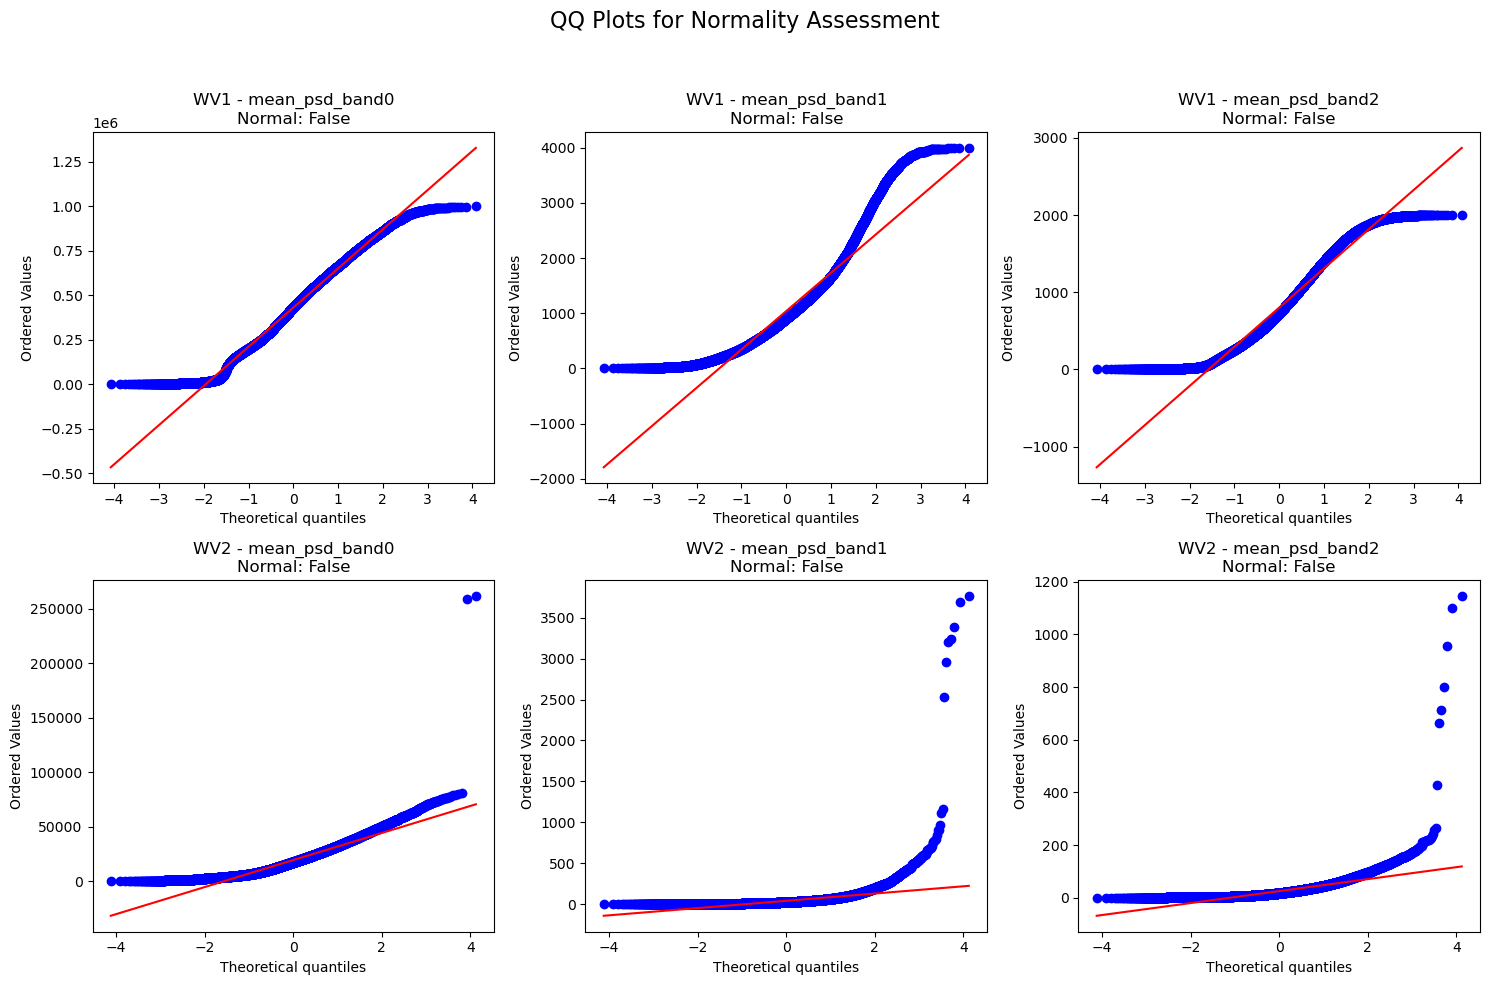

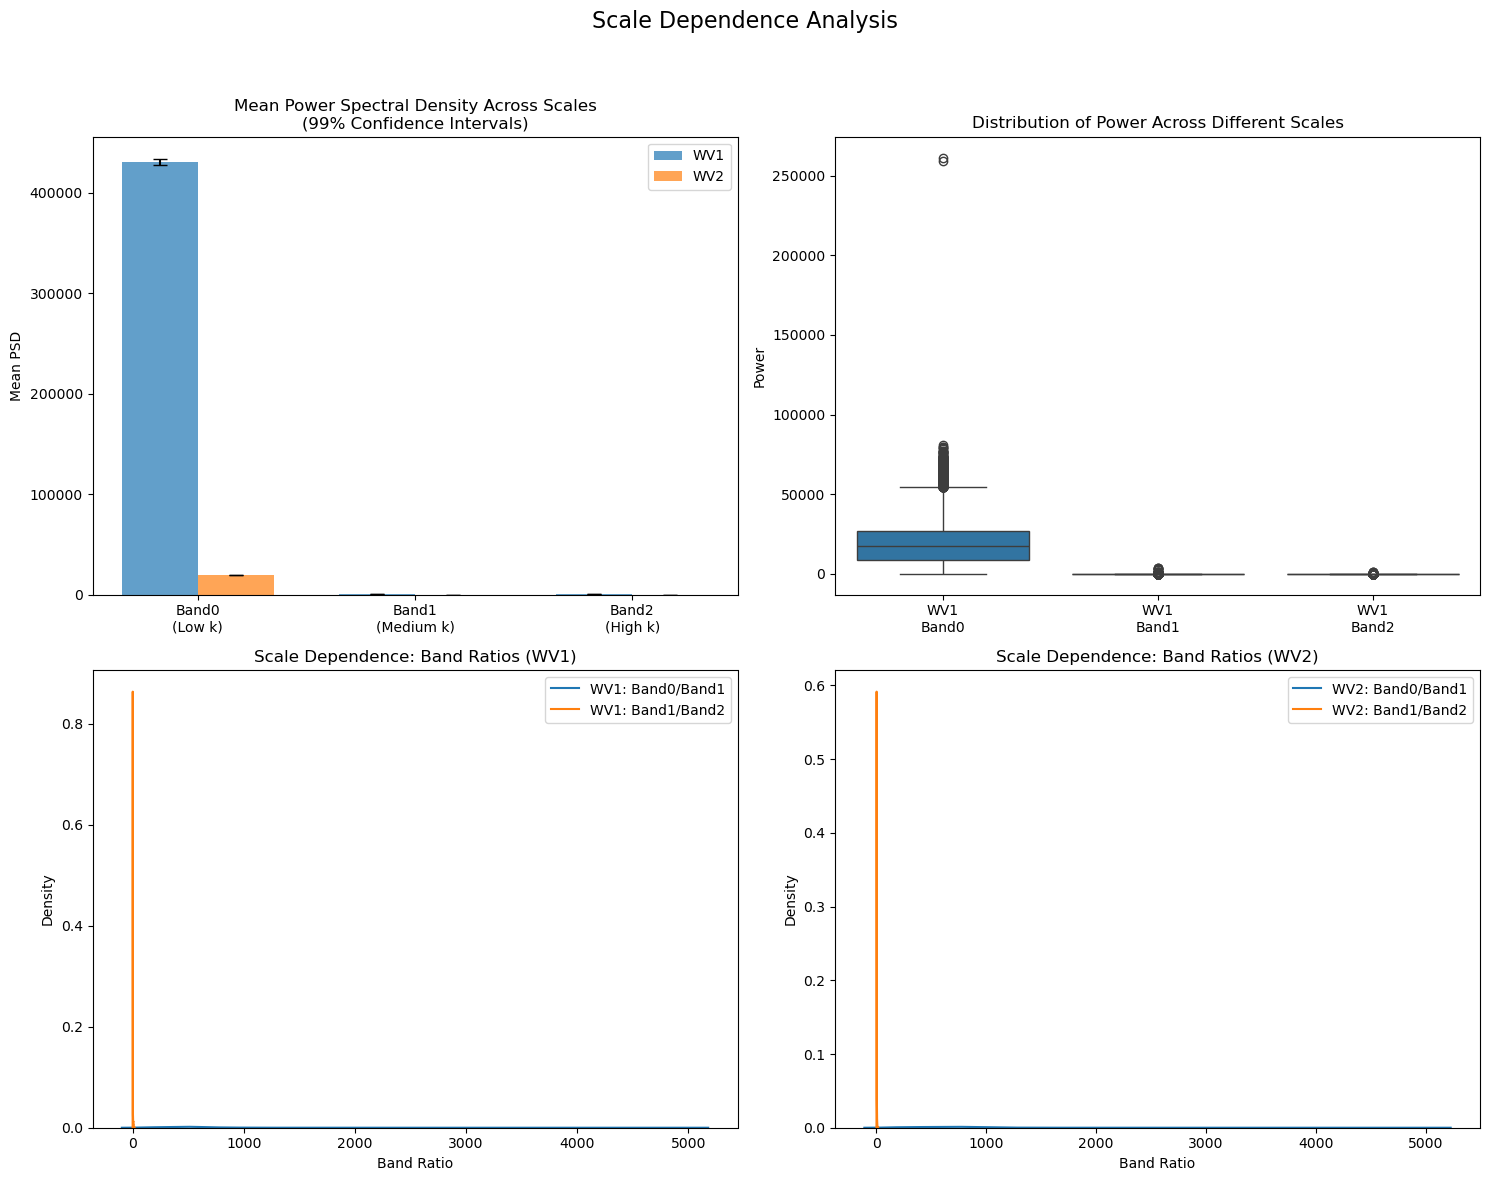

In [11]:
def check_normality(data, alpha=0.05):
    """
    Test normality of data using Shapiro-Wilk test
    
    Parameters:
    -----------
    data : array-like
        Data to test
    alpha : float
        Significance level
    
    Returns:
    --------
    bool
        True if data appears normally distributed
    dict
        Test results
    """
    # Shapiro-Wilk test (most powerful normality test)
    stat, p_value = shapiro(data)
    
    # QQ plot data for visualization
    qq_x = np.linspace(0, 1, len(data))
    qq_y = np.sort(data)
    
    return p_value > alpha, {
        'test': 'Shapiro-Wilk',
        'statistic': stat,
        'p_value': p_value,
        'normal': p_value > alpha,
        'qq_data': (qq_x, qq_y)
    }

def bootstrap_confidence_intervals(data, n_bootstrap=1000, confidence=0.99):
    """
    Calculate bootstrap confidence intervals for the mean, variance, and skewness
    
    Parameters:
    -----------
    data : array-like
        Data to bootstrap
    n_bootstrap : int
        Number of bootstrap samples
    confidence : float
        Confidence level (between 0 and 1)
    
    Returns:
    --------
    dict
        Dictionary with confidence intervals for each statistic
    """
    bootstrap_means = []
    bootstrap_vars = []
    bootstrap_skews = []
    
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstrap_means.append(np.mean(sample))
        bootstrap_vars.append(np.var(sample))
        bootstrap_skews.append(stats.skew(sample))
    
    lower_quantile = (1 - confidence) / 2
    upper_quantile = 1 - lower_quantile
    
    return {
        'mean': (np.quantile(bootstrap_means, lower_quantile), 
                 np.quantile(bootstrap_means, upper_quantile)),
        'variance': (np.quantile(bootstrap_vars, lower_quantile), 
                     np.quantile(bootstrap_vars, upper_quantile)),
        'skewness': (np.quantile(bootstrap_skews, lower_quantile), 
                     np.quantile(bootstrap_skews, upper_quantile))
    }

def test_scale_dependence(df, band1_col, band2_col, alpha=0.05):
    """
    Test for scale dependence between two frequency bands
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the band data
    band1_col : str
        Column name for the first band
    band2_col : str
        Column name for the second band
    alpha : float
        Significance level
    
    Returns:
    --------
    dict
        Dictionary with test results
    """
    # Remove NaN values
    valid_data = df[[band1_col, band2_col]].dropna()
    
    # Check normality of each band
    is_normal_band1, norm_test_band1 = check_normality(valid_data[band1_col])
    is_normal_band2, norm_test_band2 = check_normality(valid_data[band2_col])
    both_normal = is_normal_band1 and is_normal_band2
    
    # Test for equality of variances using both Levene (robust) and Bartlett (more power if normal)
    levene_stat, levene_pvalue = levene(valid_data[band1_col], valid_data[band2_col])
    bartlett_stat, bartlett_pvalue = bartlett(valid_data[band1_col], valid_data[band2_col])
    
    # Use more robust Levene's test by default, but consider Bartlett if data are normal
    equal_var_test = "Bartlett's test" if both_normal else "Levene's test"
    equal_var_pvalue = bartlett_pvalue if both_normal else levene_pvalue
    equal_var = equal_var_pvalue > alpha
    
    # Choose appropriate tests based on normality
    if both_normal:
        # Parametric test for means
        t_stat, t_pvalue = ttest_ind(valid_data[band1_col], valid_data[band2_col], equal_var=equal_var)
        first_moment_test = "Student's t-test" if equal_var else "Welch's t-test"
        first_moment_stat = t_stat
        first_moment_pvalue = t_pvalue
    else:
        # Non-parametric test for means (Mann-Whitney U test)
        u_stat, u_pvalue = stats.mannwhitneyu(valid_data[band1_col], valid_data[band2_col])
        first_moment_test = "Mann-Whitney U test"
        first_moment_stat = u_stat
        first_moment_pvalue = u_pvalue
    
    # Distribution test (Kolmogorov-Smirnov)
    ks_stat, ks_pvalue = ks_2samp(valid_data[band1_col], valid_data[band2_col])
    
    return {
        'normality': {
            'band1': {
                'test': norm_test_band1['test'],
                'p_value': norm_test_band1['p_value'],
                'normal': norm_test_band1['normal']
            },
            'band2': {
                'test': norm_test_band2['test'],
                'p_value': norm_test_band2['p_value'],
                'normal': norm_test_band2['normal']
            },
            'both_normal': both_normal
        },
        'first_moment': {
            'test': first_moment_test,
            'statistic': first_moment_stat,
            'p_value': first_moment_pvalue,
            'significant': first_moment_pvalue < alpha
        },
        'second_moment': {
            'test': equal_var_test,
            'levene': {'statistic': levene_stat, 'p_value': levene_pvalue},
            'bartlett': {'statistic': bartlett_stat, 'p_value': bartlett_pvalue},
            'p_value': equal_var_pvalue,
            'significant': equal_var_pvalue < alpha
        },
        'distribution': {
            'test': 'Kolmogorov-Smirnov test',
            'statistic': ks_stat,
            'p_value': ks_pvalue,
            'significant': ks_pvalue < alpha
        }
    }

def perform_omnibus_tests(df, band_columns, alpha=0.05):
    """
    Perform omnibus tests across all bands before pairwise comparisons
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the band data
    band_columns : list
        List of column names for the bands
    alpha : float
        Significance level
    
    Returns:
    --------
    dict
        Dictionary with test results
    """
    # Prepare data for testing
    data_for_test = [df[band].dropna().values for band in band_columns]
    
    # Check normality of all bands
    normality_results = [check_normality(band_data)[0] for band_data in data_for_test]
    all_normal = all(normality_results)
    
    # Test for homogeneity of variances
    _, levene_pvalue = levene(*data_for_test)
    equal_var = levene_pvalue > alpha
    
    # Choose appropriate omnibus test
    if all_normal and equal_var:
        # One-way ANOVA (parametric)
        f_stat, f_pvalue = f_oneway(*data_for_test)
        test_name = "One-way ANOVA"
        statistic = f_stat
        p_value = f_pvalue
    else:
        # Kruskal-Wallis H-test (non-parametric)
        h_stat, h_pvalue = kruskal(*data_for_test)
        test_name = "Kruskal-Wallis H-test"
        statistic = h_stat
        p_value = h_pvalue
    
    return {
        'test': test_name,
        'statistic': statistic,
        'p_value': p_value,
        'significant': p_value < alpha,
        'all_normal': all_normal,
        'equal_var': equal_var
    }

# Adjust p-values for multiple comparisons
def adjust_pvalues(p_values, method='bonferroni'):
    """
    Adjust p-values for multiple comparisons
    
    Parameters:
    -----------
    p_values : array-like
        Array of p-values
    method : str
        Method for adjustment ('bonferroni', 'holm', 'fdr_bh')
    
    Returns:
    --------
    array
        Adjusted p-values
    """
    # return stats.multitest.multipletests(p_values, method=method)[1]
    return multipletests(p_values, method=method)[1]

# Main analysis function
def analyze_scale_dependence(df_wv1, df_wv2, bootstrap_samples=1000, confidence=0.99, alpha=0.05):
    """
    Comprehensive analysis of scale dependence
    
    Parameters:
    -----------
    df_wv1, df_wv2 : pandas.DataFrame
        DataFrames containing band data for WV1 and WV2
    bootstrap_samples : int
        Number of bootstrap samples
    confidence : float
        Confidence level for bootstrap intervals
    alpha : float
        Significance level for hypothesis tests
    
    Returns:
    --------
    dict
        Dictionary with complete analysis results
    """
    print("Performing comprehensive scale dependence analysis...")
    
    # Define band columns and pairs for comparison
    band_columns = ['mean_psd_band0', 'mean_psd_band1', 'mean_psd_band2']
    band_pairs = [
        ('mean_psd_band0', 'mean_psd_band1'),
        ('mean_psd_band1', 'mean_psd_band2'),
        ('mean_psd_band0', 'mean_psd_band2')
    ]
    
    # Results dictionary
    results = {
        'WV1': {'bootstrap': {}, 'omnibus': None, 'pairwise': {}},
        'WV2': {'bootstrap': {}, 'omnibus': None, 'pairwise': {}}
    }
    
    # 1. Normality check and visualization
    print("\nChecking normality of distributions...")
    
    # Create QQ plots for visual inspection of normality
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('QQ Plots for Normality Assessment', fontsize=16)
    
    for i, (dataset_name, df) in enumerate([('WV1', df_wv1), ('WV2', df_wv2)]):
        for j, band in enumerate(band_columns):
            data = df[band].dropna().values
            is_normal, norm_test = check_normality(data)
            
            # Plot QQ plot
            ax = axes[i, j]
            stats.probplot(data, dist="norm", plot=ax)
            ax.set_title(f"{dataset_name} - {band}\nNormal: {is_normal}")
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig('images/normality_qq_plots.png', dpi=300)
    
    # 2. Bootstrap confidence intervals
    print("\nComputing bootstrap confidence intervals...")
    
    for dataset_name, df in [('WV1', df_wv1), ('WV2', df_wv2)]:
        for band in band_columns:
            valid_data = df[band].dropna().values
            results[dataset_name]['bootstrap'][band] = bootstrap_confidence_intervals(
                valid_data, n_bootstrap=bootstrap_samples, confidence=confidence
            )
    
    # 3. Omnibus tests
    print("\nPerforming omnibus tests across all bands...")
    
    for dataset_name, df in [('WV1', df_wv1), ('WV2', df_wv2)]:
        results[dataset_name]['omnibus'] = perform_omnibus_tests(df, band_columns, alpha=alpha)
        
        is_significant = results[dataset_name]['omnibus']['significant']
        test_name = results[dataset_name]['omnibus']['test']
        p_value = results[dataset_name]['omnibus']['p_value']
        
        print(f"  {dataset_name} - {test_name}: p-value = {p_value:.6f} "
              f"({'SIGNIFICANT' if is_significant else 'not significant'})")
    
    # 4. Pairwise tests (only if omnibus test is significant)
    print("\nPerforming pairwise comparisons between bands...")
    
    for dataset_name, df in [('WV1', df_wv1), ('WV2', df_wv2)]:
        if results[dataset_name]['omnibus']['significant']:
            # Collect p-values for adjustment
            first_moment_pvalues = []
            second_moment_pvalues = []
            distribution_pvalues = []
            
            # Perform pairwise tests
            for band1, band2 in band_pairs:
                test_result = test_scale_dependence(df, band1, band2, alpha=alpha)
                results[dataset_name]['pairwise'][(band1, band2)] = test_result
                
                first_moment_pvalues.append(test_result['first_moment']['p_value'])
                second_moment_pvalues.append(test_result['second_moment']['p_value'])
                distribution_pvalues.append(test_result['distribution']['p_value'])
            
            # Adjust p-values for multiple comparisons
            adjusted_first = adjust_pvalues(first_moment_pvalues)
            adjusted_second = adjust_pvalues(second_moment_pvalues)
            adjusted_distribution = adjust_pvalues(distribution_pvalues)
            
            # Store adjusted p-values
            for i, (band1, band2) in enumerate(band_pairs):
                results[dataset_name]['pairwise'][(band1, band2)]['first_moment']['adjusted_p_value'] = adjusted_first[i]
                results[dataset_name]['pairwise'][(band1, band2)]['second_moment']['adjusted_p_value'] = adjusted_second[i]
                results[dataset_name]['pairwise'][(band1, band2)]['distribution']['adjusted_p_value'] = adjusted_distribution[i]
    
    # 5. Create visualization
    print("\nGenerating visualizations...")
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Scale Dependence Analysis', fontsize=16)
    
    # 5.1 Bootstrap means with confidence intervals for each band
    ax1 = axes[0, 0]
    x_labels = ['Band0\n(Low k)', 'Band1\n(Medium k)', 'Band2\n(High k)']
    
    mean_values_wv1 = [np.mean(df_wv1[band].dropna()) for band in band_columns]
    mean_values_wv2 = [np.mean(df_wv2[band].dropna()) for band in band_columns]
    
    ci_lower_wv1 = [results['WV1']['bootstrap'][band]['mean'][0] for band in band_columns]
    ci_upper_wv1 = [results['WV1']['bootstrap'][band]['mean'][1] for band in band_columns]
    ci_lower_wv2 = [results['WV2']['bootstrap'][band]['mean'][0] for band in band_columns]
    ci_upper_wv2 = [results['WV2']['bootstrap'][band]['mean'][1] for band in band_columns]
    
    x = np.arange(len(x_labels))
    width = 0.35
    
    ax1.bar(x - width/2, mean_values_wv1, width, label='WV1', alpha=0.7)
    ax1.bar(x + width/2, mean_values_wv2, width, label='WV2', alpha=0.7)
    
    ax1.errorbar(x - width/2, mean_values_wv1, 
                yerr=[np.array(mean_values_wv1) - np.array(ci_lower_wv1), 
                      np.array(ci_upper_wv1) - np.array(mean_values_wv1)],
                fmt='none', color='k', capsize=5)
    
    ax1.errorbar(x + width/2, mean_values_wv2, 
                yerr=[np.array(mean_values_wv2) - np.array(ci_lower_wv2), 
                      np.array(ci_upper_wv2) - np.array(mean_values_wv2)],
                fmt='none', color='k', capsize=5)
    
    ax1.set_xticks(x)
    ax1.set_xticklabels(x_labels)
    ax1.set_ylabel('Mean PSD')
    ax1.set_title(f'Mean Power Spectral Density Across Scales\n(99% Confidence Intervals)')
    ax1.legend()
    
    # 5.2 Distribution of each band
    ax2 = axes[0, 1]
    
    data_to_plot = [
        df_wv1['mean_psd_band0'].dropna(),
        df_wv1['mean_psd_band1'].dropna(),
        df_wv1['mean_psd_band2'].dropna(),
        df_wv2['mean_psd_band0'].dropna(),
        df_wv2['mean_psd_band1'].dropna(),
        df_wv2['mean_psd_band2'].dropna()
    ]
    
    sns.boxplot(data=data_to_plot, ax=ax2)
    ax2.set_xticklabels(['WV1\nBand0', 'WV1\nBand1', 'WV1\nBand2', 
                         'WV2\nBand0', 'WV2\nBand1', 'WV2\nBand2'])
    ax2.set_ylabel('Power')
    ax2.set_title('Distribution of Power Across Different Scales')
    
    # 5.3 Scale dependence visualization: Band ratios
    ax3 = axes[1, 0]
    
    sns.kdeplot(df_wv1['mean_psd_band0']/df_wv1['mean_psd_band1'], label='WV1: Band0/Band1', ax=ax3)
    sns.kdeplot(df_wv1['mean_psd_band1']/df_wv1['mean_psd_band2'], label='WV1: Band1/Band2', ax=ax3)
    
    ax3.set_xlabel('Band Ratio')
    ax3.set_ylabel('Density')
    ax3.set_title('Scale Dependence: Band Ratios (WV1)')
    ax3.legend()
    
    ax4 = axes[1, 1]
    
    sns.kdeplot(df_wv2['mean_psd_band0']/df_wv2['mean_psd_band1'], label='WV2: Band0/Band1', ax=ax4)
    sns.kdeplot(df_wv2['mean_psd_band1']/df_wv2['mean_psd_band2'], label='WV2: Band1/Band2', ax=ax4)
    
    ax4.set_xlabel('Band Ratio')
    ax4.set_ylabel('Density')
    ax4.set_title('Scale Dependence: Band Ratios (WV2)')
    ax4.legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig('images/scale_dependence_analysis.png', dpi=300)
    
    # 6. Create summary DataFrame 
    print("\nCreating summary tables...")
    
    # Prepare summary data
    summary_columns = [
        'Comparison', 'Dataset', 'Normality', 'First Moment Test', 
        'First Moment p-value', 'Adjusted p-value', 'Second Moment p-value', 
        'KS Test p-value', 'Scale Dependent?'
    ]
    
    summary_data = []
    
    for dataset_name, df in [('WV1', df_wv1), ('WV2', df_wv2)]:
        # Add omnibus test result
        omnibus_result = results[dataset_name]['omnibus']
        summary_data.append([
            'All bands', dataset_name, 
            'All normal' if omnibus_result['all_normal'] else 'Not all normal',
            omnibus_result['test'], omnibus_result['p_value'], 'N/A', 'N/A', 'N/A',
            'Yes' if omnibus_result['significant'] else 'No'
        ])
        
        # Add pairwise comparison results
        for band1, band2 in band_pairs:
            if not omnibus_result['significant']:
                # Skip pairwise tests if omnibus test is not significant
                continue
                
            results_pair = results[dataset_name]['pairwise'][(band1, band2)]
            both_normal = results_pair['normality']['both_normal']
            
            first_moment_test = results_pair['first_moment']['test']
            first_moment_pvalue = results_pair['first_moment']['p_value']
            first_moment_adj_pvalue = results_pair['first_moment']['adjusted_p_value']
            
            second_moment_pvalue = results_pair['second_moment']['p_value']
            ks_pvalue = results_pair['distribution']['p_value']
            
            scale_dependent = (
                results_pair['first_moment']['significant'] or
                results_pair['second_moment']['significant'] or
                results_pair['distribution']['significant']
            )
            
            summary_data.append([
                f"{band1} vs {band2}", dataset_name, 
                'Both normal' if both_normal else 'Non-normal',
                first_moment_test, first_moment_pvalue, first_moment_adj_pvalue,
                second_moment_pvalue, ks_pvalue,
                'Yes' if scale_dependent else 'No'
            ])
    
    summary_df = pd.DataFrame(summary_data, columns=summary_columns)
        
    return results, summary_df

# Execute the analysis
results, summary = analyze_scale_dependence(df_wv1, df_wv2, bootstrap_samples=1000, confidence=0.99)

### Analysis Workflow

In this workflow, we aimed to assess scale dependence across different bands in our dataset using nonparametric, **median-based** statistical methods. Following practices outlined in **Wilks (2019) _Statistical Methods in the Atmospheric Sciences (4th edition)_**, we structured our analysis to carefully address normality assumptions, robust estimators, and hypothesis testing for multiple comparisons.

#### Checking for Normality

First verify the distribution assumption before deciding which staitistical test to apply. Checks for **normality** on each band using the Shapiro–Wilk test (basically asking: "Does this data follow a bell curve?"). For visual exploration, it also generates **Q–Q plots**. 

Because many of our data distributions exhibit outliers and heavy tails, we opt for nonparametric approaches. For example, we adopt the Mann–Whitney U test in place of a classical t-test (basically asking: "If I randomly select a value from band0 and a value from band1, what's the probability the band0 value is larger?"). Rather than directly comparing means (which can be heavily influenced by outliers), Mann–Whitney compares the entire distributions to detect if one tends to contain larger values than the other—making it much more robust when dealing with skewed data like ours. Similarly, we employ Mood's median test to specifically examine differences in central tendency (basically asking: "Is the median of band0 different from the median of band1?"). This test works by counting how many observations in each group fall above or below the combined median, making it particularly effective when distributions differ in shape but we still want to compare their centers.

Wilks (2019) also describes the importance of bootstrap methods for estimating confidence intervals in the face of nonnormal data. Hence, we define a `bootstrap_confidence_intervals` function that resamples (with replacement) our array multiple times to compute empirical confidence bounds for robust statistics: the median, interquartile range (IQR), and skewness (basically asking: "If we had collected many different samples, what range would likely contain the true median?"). This approach gives us a distribution-free view of parameter uncertainty.

After these individual checks, we carry out an **omnibus test** (the Kruskal–Wallis H-test) across all bands at once (basically asking: "Is there any difference at all among these three bands?"). If this indicates significant group differences, we proceed with **pairwise** Mann–Whitney tests (basically asking: "Which specific pairs of bands differ from each other?"), plus p-value adjustments for multiple comparisons. Additionally, a **Kolmogorov–Smirnov (K–S) test** checks overall distributional differences beyond just location or scale (basically asking: "Do these two bands follow completely different distributions?"). Finally, we produce a variety of visualizations, including boxplots, violin plots, and ratio plots, to illustrate distribution shapes and how each band relates to the others.

Throughout, the methodology mirrors core principles from _Statistical Methods in the Atmospheric Sciences_—particularly in verifying assumptions, choosing appropriate nonparametric tests if data are not normal, and handling the multiple testing scenario. This code thus provides a comprehensive, robust approach for investigating scale-dependent phenomena without relying heavily on strict normality assumptions.

The band ratios (Band0/Band1 and Band1/Band2) provide direct evidence of scale dependence in our data, showing how power drops as we move from larger to smaller scales. These ratios are particularly relevant to our research question about whether wind stress fields exhibit significant variations across different spatial scales. The logarithmic differences we observe suggest that energy in ocean-atmosphere interactions is not uniformly distributed across scales, which has important implications for modeling and understanding scale-dependent physical processes.

Performing comprehensive scale dependence analysis using median-based methods...

Checking normality of distributions...


c:\Users\gui-win10\miniconda3\envs\msc-thesis\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 30187.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\gui-win10\miniconda3\envs\msc-thesis\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 36941.
  res = hypotest_fun_out(*samples, **kwds)



Computing bootstrap confidence intervals for medians...

Performing omnibus tests across all bands...
  WV1 - Kruskal-Wallis H-test: p-value = 0.000000 (SIGNIFICANT)
  WV2 - Kruskal-Wallis H-test: p-value = 0.000000 (SIGNIFICANT)

Performing pairwise comparisons between bands...


c:\Users\gui-win10\miniconda3\envs\msc-thesis\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 30187.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\gui-win10\miniconda3\envs\msc-thesis\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 30187.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\gui-win10\miniconda3\envs\msc-thesis\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 30187.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\gui-win10\miniconda3\envs\msc-thesis\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 36941.
  res = hypotest_fun_out(*samples, **kwds)



Generating visualizations...


C:\Users\gui-win10\AppData\Local\Temp\ipykernel_38620\158227855.py:455: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(['WV1', 'WV2'])
C:\Users\gui-win10\AppData\Local\Temp\ipykernel_38620\158227855.py:462: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(['WV1', 'WV2'])
C:\Users\gui-win10\AppData\Local\Temp\ipykernel_38620\158227855.py:469: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax5.set_xticklabels(['WV1', 'WV2'])
C:\Users\gui-win10\AppData\Local\Temp\ipykernel_38620\158227855.py:583: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Dataset', y


Creating summary tables...


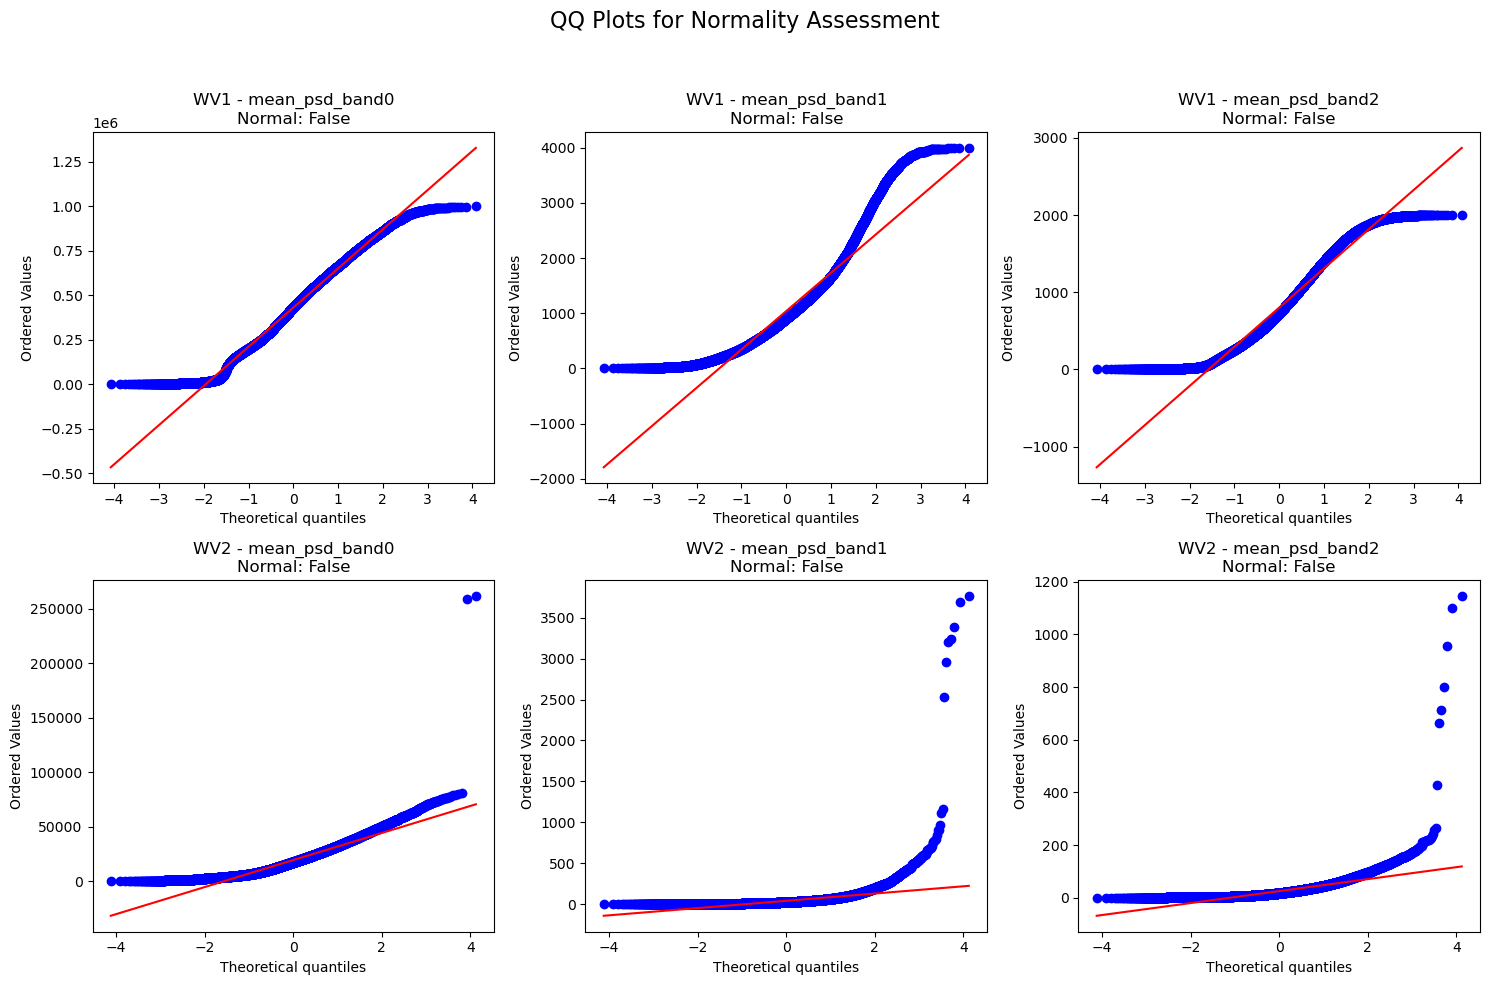

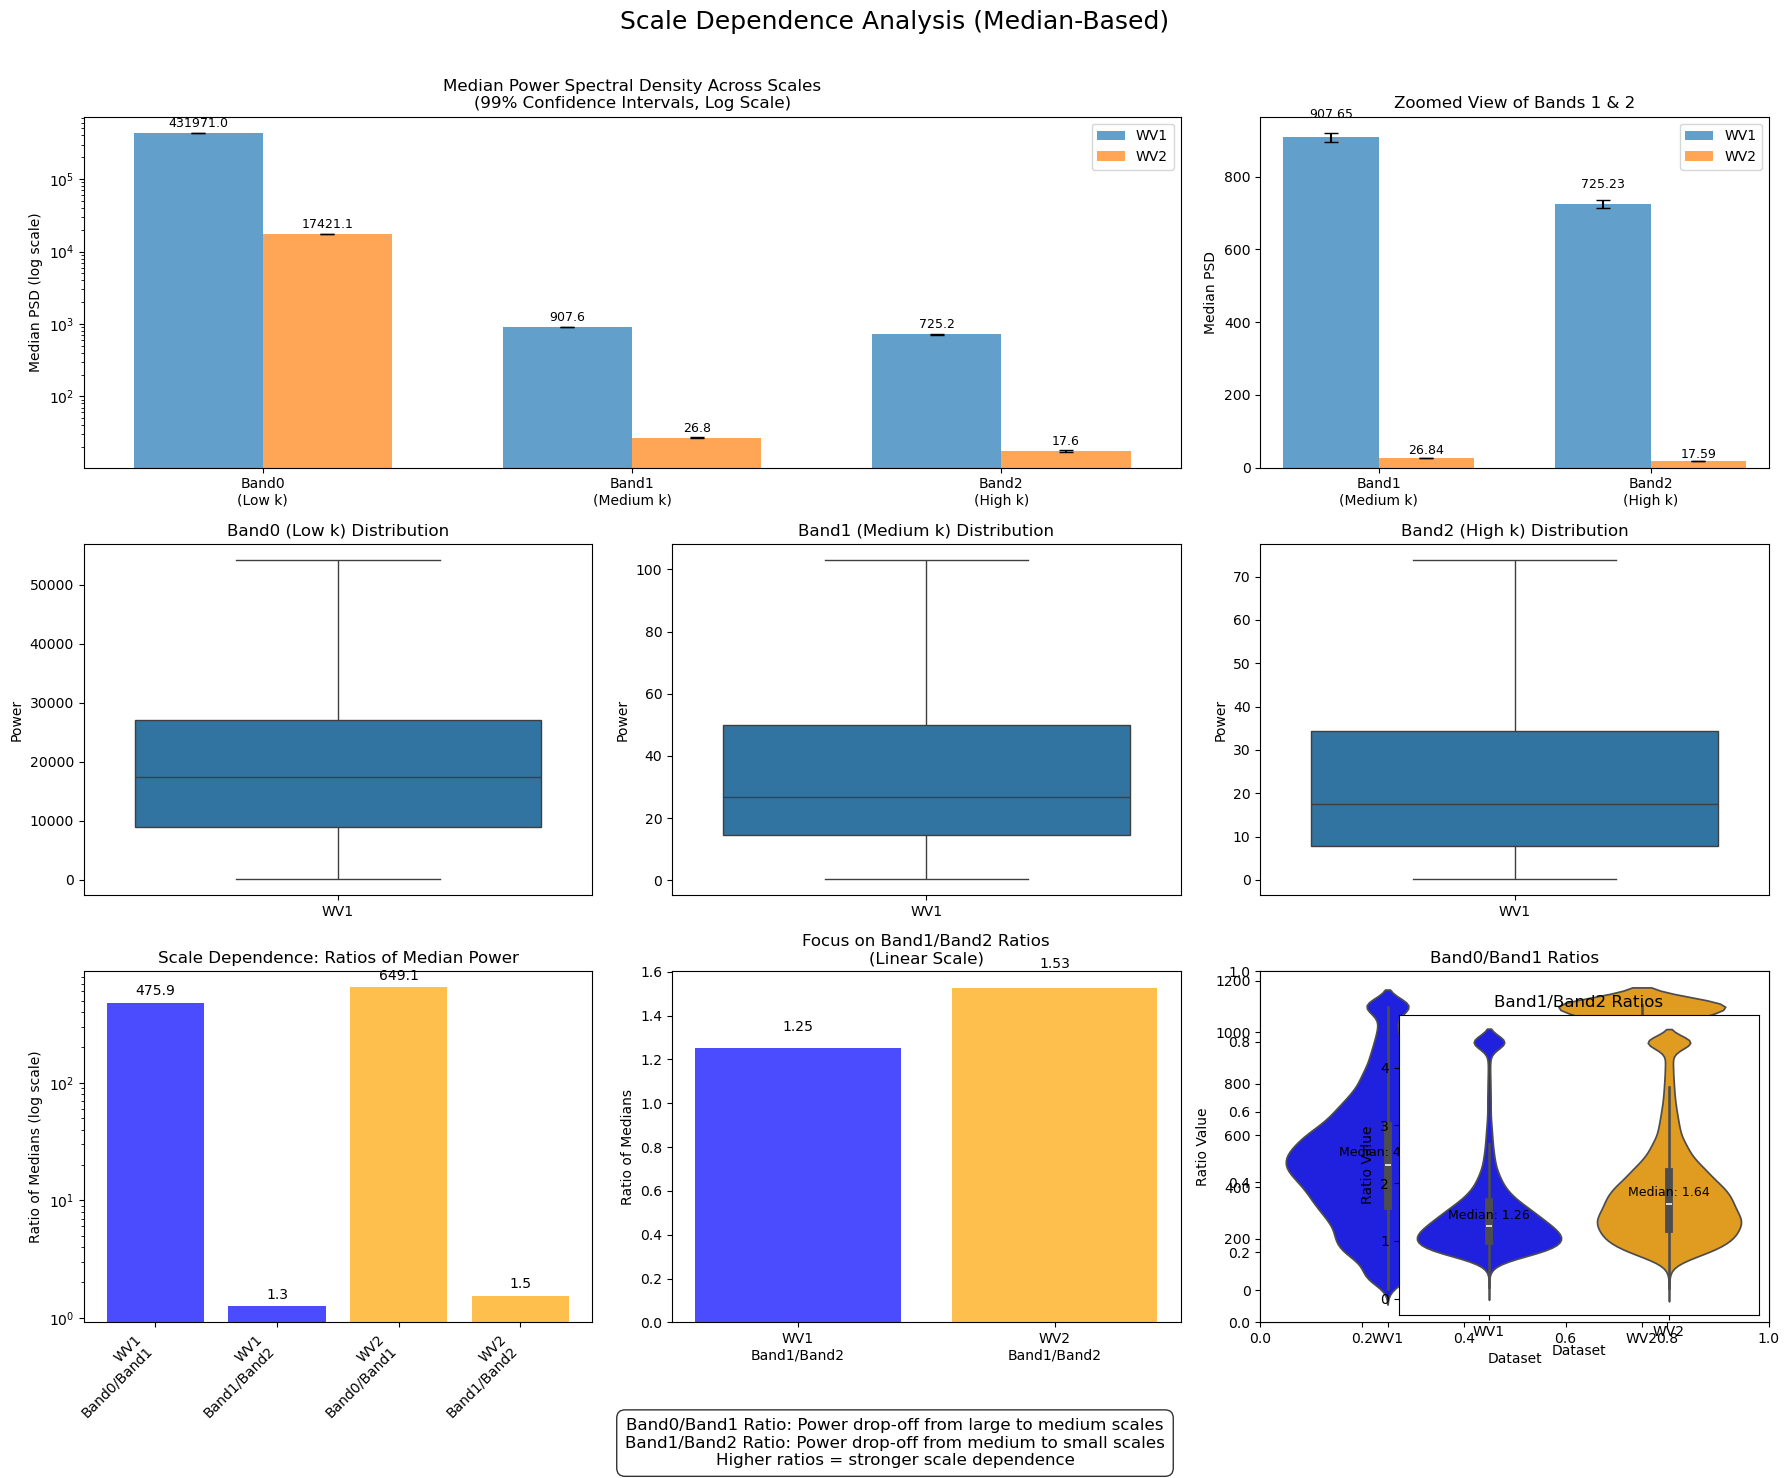

In [12]:
# Import for multiple testing correction
try:
    from statsmodels.stats.multitest import multipletests
except ImportError:
    # Fallback implementation if statsmodels is not available
    def multipletests(p_values, method='bonferroni'):
        if method == 'bonferroni':
            return [True if p * len(p_values) < 0.05 else False for p in p_values], [min(p * len(p_values), 1.0) for p in p_values]
        else:
            return [True if p < 0.05 else False for p in p_values], p_values

def check_normality(data, alpha=0.05):
    """
    Test normality of data using Shapiro-Wilk test
    
    Parameters:
    -----------
    data : array-like
        Data to test
    alpha : float
        Significance level
    
    Returns:
    --------
    bool
        True if data appears normally distributed
    dict
        Test results
    """
    # Shapiro-Wilk test (most powerful normality test)
    stat, p_value = shapiro(data)
    
    # QQ plot data for visualization
    qq_x = np.linspace(0, 1, len(data))
    qq_y = np.sort(data)
    
    return p_value > alpha, {
        'test': 'Shapiro-Wilk',
        'statistic': stat,
        'p_value': p_value,
        'normal': p_value > alpha,
        'qq_data': (qq_x, qq_y)
    }

def bootstrap_confidence_intervals(data, n_bootstrap=1000, confidence=0.99):
    """
    Calculate bootstrap confidence intervals for the median, IQR, and skewness
    
    Parameters:
    -----------
    data : array-like
        Data to bootstrap
    n_bootstrap : int
        Number of bootstrap samples
    confidence : float
        Confidence level (between 0 and 1)
    
    Returns:
    --------
    dict
        Dictionary with confidence intervals for each statistic
    """
    bootstrap_medians = []
    bootstrap_iqrs = []
    bootstrap_skews = []
    
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstrap_medians.append(np.median(sample))
        # Calculate IQR (Q3 - Q1) as a robust measure of dispersion
        q1, q3 = np.percentile(sample, [25, 75])
        bootstrap_iqrs.append(q3 - q1)
        bootstrap_skews.append(stats.skew(sample))
    
    lower_quantile = (1 - confidence) / 2
    upper_quantile = 1 - lower_quantile
    
    return {
        'median': (np.quantile(bootstrap_medians, lower_quantile), 
                   np.quantile(bootstrap_medians, upper_quantile)),
        'iqr': (np.quantile(bootstrap_iqrs, lower_quantile), 
                np.quantile(bootstrap_iqrs, upper_quantile)),
        'skewness': (np.quantile(bootstrap_skews, lower_quantile), 
                     np.quantile(bootstrap_skews, upper_quantile))
    }

def test_scale_dependence(df, band1_col, band2_col, alpha=0.05):
    """
    Test for scale dependence between two frequency bands
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the band data
    band1_col : str
        Column name for the first band
    band2_col : str
        Column name for the second band
    alpha : float
        Significance level
    
    Returns:
    --------
    dict
        Dictionary with test results
    """
    # Remove NaN values
    valid_data = df[[band1_col, band2_col]].dropna()
    
    # Check normality of each band
    is_normal_band1, norm_test_band1 = check_normality(valid_data[band1_col])
    is_normal_band2, norm_test_band2 = check_normality(valid_data[band2_col])
    both_normal = is_normal_band1 and is_normal_band2
    
    # Test for equality of variances using both Levene (robust) and Bartlett (more power if normal)
    levene_stat, levene_pvalue = levene(valid_data[band1_col], valid_data[band2_col])
    bartlett_stat, bartlett_pvalue = bartlett(valid_data[band1_col], valid_data[band2_col])
    
    # Use more robust Levene's test by default, but consider Bartlett if data are normal
    equal_var_test = "Bartlett's test" if both_normal else "Levene's test"
    equal_var_pvalue = bartlett_pvalue if both_normal else levene_pvalue
    equal_var = equal_var_pvalue > alpha
    
    # We'll use non-parametric tests since we're focusing on medians
    # Non-parametric test for location (Mann-Whitney U test)
    u_stat, u_pvalue = stats.mannwhitneyu(valid_data[band1_col], valid_data[band2_col])
    first_moment_test = "Mann-Whitney U test"
    first_moment_stat = u_stat
    first_moment_pvalue = u_pvalue
    
    # Non-parametric test for scale (Mood's median test)
    # mood_stat, mood_pvalue = stats.median_test(valid_data[band1_col], valid_data[band2_col])
    mood_stat, mood_pvalue, _, _ = stats.median_test(valid_data[band1_col], valid_data[band2_col])
    second_moment_test = "Mood's median test"
    second_moment_stat = mood_stat
    second_moment_pvalue = mood_pvalue
    
    # Distribution test (Kolmogorov-Smirnov)
    ks_stat, ks_pvalue = ks_2samp(valid_data[band1_col], valid_data[band2_col])
    
    return {
        'normality': {
            'band1': {
                'test': norm_test_band1['test'],
                'p_value': norm_test_band1['p_value'],
                'normal': norm_test_band1['normal']
            },
            'band2': {
                'test': norm_test_band2['test'],
                'p_value': norm_test_band2['p_value'],
                'normal': norm_test_band2['normal']
            },
            'both_normal': both_normal
        },
        'first_moment': {
            'test': first_moment_test,
            'statistic': first_moment_stat,
            'p_value': first_moment_pvalue,
            'significant': first_moment_pvalue < alpha
        },
        'second_moment': {
            'test': second_moment_test,
            'statistic': second_moment_stat,
            'p_value': second_moment_pvalue,
            'significant': second_moment_pvalue < alpha,
            'levene': {'statistic': levene_stat, 'p_value': levene_pvalue},
            'bartlett': {'statistic': bartlett_stat, 'p_value': bartlett_pvalue}
        },
        'distribution': {
            'test': 'Kolmogorov-Smirnov test',
            'statistic': ks_stat,
            'p_value': ks_pvalue,
            'significant': ks_pvalue < alpha
        }
    }

def perform_omnibus_tests(df, band_columns, alpha=0.05):
    """
    Perform omnibus tests across all bands before pairwise comparisons
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the band data
    band_columns : list
        List of column names for the bands
    alpha : float
        Significance level
    
    Returns:
    --------
    dict
        Dictionary with test results
    """
    # Prepare data for testing
    data_for_test = [df[band].dropna().values for band in band_columns]
    
    # Check normality of all bands
    normality_results = [check_normality(band_data)[0] for band_data in data_for_test]
    all_normal = all(normality_results)
    
    # For non-parametric analysis (focusing on medians), we'll use Kruskal-Wallis
    # Kruskal-Wallis H-test (non-parametric alternative to one-way ANOVA)
    h_stat, h_pvalue = kruskal(*data_for_test)
    test_name = "Kruskal-Wallis H-test"
    statistic = h_stat
    p_value = h_pvalue
    
    return {
        'test': test_name,
        'statistic': statistic,
        'p_value': p_value,
        'significant': p_value < alpha,
        'all_normal': all_normal
    }

# Adjust p-values for multiple comparisons
def adjust_pvalues(p_values, method='bonferroni'):
    """
    Adjust p-values for multiple comparisons
    
    Parameters:
    -----------
    p_values : array-like
        Array of p-values
    method : str
        Method for adjustment ('bonferroni', 'holm', 'fdr_bh')
    
    Returns:
    --------
    array
        Adjusted p-values
    """
    return multipletests(p_values, method=method)[1]

# Main analysis function
def analyze_scale_dependence(df_wv1, df_wv2, bootstrap_samples=1000, confidence=0.99, alpha=0.05):
    """
    Comprehensive analysis of scale dependence using median-based methods
    
    Parameters:
    -----------
    df_wv1, df_wv2 : pandas.DataFrame
        DataFrames containing band data for WV1 and WV2
    bootstrap_samples : int
        Number of bootstrap samples
    confidence : float
        Confidence level for bootstrap intervals
    alpha : float
        Significance level for hypothesis tests
    
    Returns:
    --------
    dict
        Dictionary with complete analysis results
    """
    print("Performing comprehensive scale dependence analysis using median-based methods...")
    
    # Define band columns and pairs for comparison
    band_columns = ['mean_psd_band0', 'mean_psd_band1', 'mean_psd_band2']
    band_pairs = [
        ('mean_psd_band0', 'mean_psd_band1'),
        ('mean_psd_band1', 'mean_psd_band2'),
        ('mean_psd_band0', 'mean_psd_band2')
    ]
    
    # Results dictionary
    results = {
        'WV1': {'bootstrap': {}, 'omnibus': None, 'pairwise': {}},
        'WV2': {'bootstrap': {}, 'omnibus': None, 'pairwise': {}}
    }
    
    # 1. Normality check and visualization
    print("\nChecking normality of distributions...")
    
    # Create QQ plots for visual inspection of normality
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('QQ Plots for Normality Assessment', fontsize=16)
    
    for i, (dataset_name, df) in enumerate([('WV1', df_wv1), ('WV2', df_wv2)]):
        for j, band in enumerate(band_columns):
            data = df[band].dropna().values
            is_normal, norm_test = check_normality(data)
            
            # Plot QQ plot
            ax = axes[i, j]
            stats.probplot(data, dist="norm", plot=ax)
            ax.set_title(f"{dataset_name} - {band}\nNormal: {is_normal}")
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig('images/normality_qq_plots.png', dpi=300)
    
    # 2. Bootstrap confidence intervals for medians
    print("\nComputing bootstrap confidence intervals for medians...")
    
    for dataset_name, df in [('WV1', df_wv1), ('WV2', df_wv2)]:
        for band in band_columns:
            valid_data = df[band].dropna().values
            results[dataset_name]['bootstrap'][band] = bootstrap_confidence_intervals(
                valid_data, n_bootstrap=bootstrap_samples, confidence=confidence
            )
    
    # 3. Omnibus tests
    print("\nPerforming omnibus tests across all bands...")
    
    for dataset_name, df in [('WV1', df_wv1), ('WV2', df_wv2)]:
        results[dataset_name]['omnibus'] = perform_omnibus_tests(df, band_columns, alpha=alpha)
        
        is_significant = results[dataset_name]['omnibus']['significant']
        test_name = results[dataset_name]['omnibus']['test']
        p_value = results[dataset_name]['omnibus']['p_value']
        
        print(f"  {dataset_name} - {test_name}: p-value = {p_value:.6f} "
              f"({'SIGNIFICANT' if is_significant else 'not significant'})")
    
    # 4. Pairwise tests (only if omnibus test is significant)
    print("\nPerforming pairwise comparisons between bands...")
    
    for dataset_name, df in [('WV1', df_wv1), ('WV2', df_wv2)]:
        if results[dataset_name]['omnibus']['significant']:
            # Collect p-values for adjustment
            first_moment_pvalues = []
            second_moment_pvalues = []
            distribution_pvalues = []
            
            # Perform pairwise tests
            for band1, band2 in band_pairs:
                test_result = test_scale_dependence(df, band1, band2, alpha=alpha)
                results[dataset_name]['pairwise'][(band1, band2)] = test_result
                
                first_moment_pvalues.append(test_result['first_moment']['p_value'])
                second_moment_pvalues.append(test_result['second_moment']['p_value'])
                distribution_pvalues.append(test_result['distribution']['p_value'])
            
            # Adjust p-values for multiple comparisons
            adjusted_first = adjust_pvalues(first_moment_pvalues)
            adjusted_second = adjust_pvalues(second_moment_pvalues)
            adjusted_distribution = adjust_pvalues(distribution_pvalues)
            
            # Store adjusted p-values
            for i, (band1, band2) in enumerate(band_pairs):
                results[dataset_name]['pairwise'][(band1, band2)]['first_moment']['adjusted_p_value'] = adjusted_first[i]
                results[dataset_name]['pairwise'][(band1, band2)]['second_moment']['adjusted_p_value'] = adjusted_second[i]
                results[dataset_name]['pairwise'][(band1, band2)]['distribution']['adjusted_p_value'] = adjusted_distribution[i]
    
    # 5. Create visualization
    print("\nGenerating visualizations...")

    # Create a larger figure with more subplots
    fig = plt.figure(figsize=(18, 15))
    fig.suptitle('Scale Dependence Analysis (Median-Based)', fontsize=18)

    # Create a grid layout
    gs = fig.add_gridspec(3, 3)

    # 1. Log scale plot of all bands
    ax1 = fig.add_subplot(gs[0, :2])
    x_labels = ['Band0\n(Low k)', 'Band1\n(Medium k)', 'Band2\n(High k)']

    median_values_wv1 = [np.median(df_wv1[band].dropna()) for band in band_columns]
    median_values_wv2 = [np.median(df_wv2[band].dropna()) for band in band_columns]

    ci_lower_wv1 = [results['WV1']['bootstrap'][band]['median'][0] for band in band_columns]
    ci_upper_wv1 = [results['WV1']['bootstrap'][band]['median'][1] for band in band_columns]
    ci_lower_wv2 = [results['WV2']['bootstrap'][band]['median'][0] for band in band_columns]
    ci_upper_wv2 = [results['WV2']['bootstrap'][band]['median'][1] for band in band_columns]

    x = np.arange(len(x_labels))
    width = 0.35

    # Create log scale bar plot
    bars1 = ax1.bar(x - width/2, median_values_wv1, width, label='WV1', alpha=0.7)
    bars2 = ax1.bar(x + width/2, median_values_wv2, width, label='WV2', alpha=0.7)

    # Add error bars
    ax1.errorbar(x - width/2, median_values_wv1, 
                yerr=[np.array(median_values_wv1) - np.array(ci_lower_wv1), 
                    np.array(ci_upper_wv1) - np.array(median_values_wv1)],
                fmt='none', color='k', capsize=5)

    ax1.errorbar(x + width/2, median_values_wv2, 
                yerr=[np.array(median_values_wv2) - np.array(ci_lower_wv2), 
                    np.array(ci_upper_wv2) - np.array(median_values_wv2)],
                fmt='none', color='k', capsize=5)

    # Set to log scale to see all bands
    ax1.set_yscale('log')
    ax1.set_xticks(x)
    ax1.set_xticklabels(x_labels)
    ax1.set_ylabel('Median PSD (log scale)')
    ax1.set_title('Median Power Spectral Density Across Scales\n(99% Confidence Intervals, Log Scale)')
    ax1.legend()

    # Add value annotations to the bars
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height*1.1,
                f'{height:.1f}', ha='center', va='bottom', rotation=0, fontsize=9)
                
    for bar in bars2:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height*1.1,
                f'{height:.1f}', ha='center', va='bottom', rotation=0, fontsize=9)

    # 2. Linear scale plot focusing on bands 1 and 2 only
    ax2 = fig.add_subplot(gs[0, 2])
    x_labels_small = ['Band1\n(Medium k)', 'Band2\n(High k)']
    x_small = np.arange(len(x_labels_small))

    # Extract just bands 1 and 2
    median_values_wv1_small = median_values_wv1[1:]
    median_values_wv2_small = median_values_wv2[1:]
    ci_lower_wv1_small = ci_lower_wv1[1:]
    ci_upper_wv1_small = ci_upper_wv1[1:]
    ci_lower_wv2_small = ci_lower_wv2[1:]
    ci_upper_wv2_small = ci_upper_wv2[1:]

    # Create linear scale bar plot for just bands 1 and 2
    bars1_small = ax2.bar(x_small - width/2, median_values_wv1_small, width, label='WV1', alpha=0.7)
    bars2_small = ax2.bar(x_small + width/2, median_values_wv2_small, width, label='WV2', alpha=0.7)

    # Add error bars
    ax2.errorbar(x_small - width/2, median_values_wv1_small, 
                yerr=[np.array(median_values_wv1_small) - np.array(ci_lower_wv1_small), 
                    np.array(ci_upper_wv1_small) - np.array(median_values_wv1_small)],
                fmt='none', color='k', capsize=5)

    ax2.errorbar(x_small + width/2, median_values_wv2_small, 
                yerr=[np.array(median_values_wv2_small) - np.array(ci_lower_wv2_small), 
                    np.array(ci_upper_wv2_small) - np.array(median_values_wv2_small)],
                fmt='none', color='k', capsize=5)

    ax2.set_xticks(x_small)
    ax2.set_xticklabels(x_labels_small)
    ax2.set_ylabel('Median PSD')
    ax2.set_title('Zoomed View of Bands 1 & 2')
    ax2.legend()

    # Add value annotations
    for bar in bars1_small:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height*1.05,
                f'{height:.2f}', ha='center', va='bottom', fontsize=9)
                
    for bar in bars2_small:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height*1.05,
                f'{height:.2f}', ha='center', va='bottom', fontsize=9)

    # 3. Distribution boxplots with separate axes for each band
    # Create three separate boxplots for each band with their own y-scales
    # Band 0
    ax3 = fig.add_subplot(gs[1, 0])
    sns.boxplot(data=[df_wv1['mean_psd_band0'].dropna(), df_wv2['mean_psd_band0'].dropna()], ax=ax3, showfliers=False)
    ax3.set_xticklabels(['WV1', 'WV2'])
    ax3.set_ylabel('Power')
    ax3.set_title('Band0 (Low k) Distribution')

    # Band 1
    ax4 = fig.add_subplot(gs[1, 1])
    sns.boxplot(data=[df_wv1['mean_psd_band1'].dropna(), df_wv2['mean_psd_band1'].dropna()], ax=ax4, showfliers=False)
    ax4.set_xticklabels(['WV1', 'WV2'])
    ax4.set_ylabel('Power')
    ax4.set_title('Band1 (Medium k) Distribution')

    # Band 2
    ax5 = fig.add_subplot(gs[1, 2])
    sns.boxplot(data=[df_wv1['mean_psd_band2'].dropna(), df_wv2['mean_psd_band2'].dropna()], ax=ax5, showfliers=False)
    ax5.set_xticklabels(['WV1', 'WV2'])
    ax5.set_ylabel('Power')
    ax5.set_title('Band2 (High k) Distribution')

    # Add median values as text annotations to the boxplots
    for i, ax in enumerate([ax3, ax4, ax5]):
        band = band_columns[i]
        wv1_median = np.median(df_wv1[band].dropna())
        wv2_median = np.median(df_wv2[band].dropna())
        
        # ax.text(0, wv1_median*1.1, f'Median: {wv1_median:.2f}', 
        #         ha='center', va='bottom', fontsize=9, color='blue')
        # ax.text(1, wv2_median*1.1, f'Median: {wv2_median:.2f}', 
        #         ha='center', va='bottom', fontsize=9, color='orange')

    # 4. Scale dependence visualization: Band ratios (both log and linear scales)
    ax6 = fig.add_subplot(gs[2, 0])

    # Calculate ratios of medians
    wv1_ratio_01 = np.median(df_wv1['mean_psd_band0'])/np.median(df_wv1['mean_psd_band1'])
    wv1_ratio_12 = np.median(df_wv1['mean_psd_band1'])/np.median(df_wv1['mean_psd_band2'])
    wv2_ratio_01 = np.median(df_wv2['mean_psd_band0'])/np.median(df_wv2['mean_psd_band1'])
    wv2_ratio_12 = np.median(df_wv2['mean_psd_band1'])/np.median(df_wv2['mean_psd_band2'])

    ratio_values = [wv1_ratio_01, wv1_ratio_12, wv2_ratio_01, wv2_ratio_12]

    # Create bar plot for median ratios - Log scale
    ratio_labels = ['WV1\nBand0/Band1', 'WV1\nBand1/Band2', 'WV2\nBand0/Band1', 'WV2\nBand1/Band2']
    ratio_x = np.arange(len(ratio_labels))

    bars_ratio = ax6.bar(ratio_x, ratio_values, alpha=0.7, 
                        color=['blue', 'blue', 'orange', 'orange'])

    ax6.set_xticks(ratio_x)
    ax6.set_xticklabels(ratio_labels, rotation=45, ha='right')
    ax6.set_ylabel('Ratio of Medians (log scale)')
    ax6.set_title('Scale Dependence: Ratios of Median Power')
    ax6.set_yscale('log')  # Use log scale to see all ratios

    # Add ratio values as text
    for i, bar in enumerate(bars_ratio):
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height*1.1,
                f'{ratio_values[i]:.1f}', ha='center', va='bottom', rotation=0)

    # 5. Focus on Band1/Band2 ratios only (much smaller values)
    ax7 = fig.add_subplot(gs[2, 1])
    b12_labels = ['WV1\nBand1/Band2', 'WV2\nBand1/Band2']
    b12_x = np.arange(len(b12_labels))
    b12_values = [wv1_ratio_12, wv2_ratio_12]

    bars_b12 = ax7.bar(b12_x, b12_values, alpha=0.7, 
                    color=['blue', 'orange'])

    ax7.set_xticks(b12_x)
    ax7.set_xticklabels(b12_labels)
    ax7.set_ylabel('Ratio of Medians')
    ax7.set_title('Focus on Band1/Band2 Ratios\n(Linear Scale)')

    # Add ratio values as text
    for i, bar in enumerate(bars_b12):
        height = bar.get_height()
        ax7.text(bar.get_x() + bar.get_width()/2., height*1.05,
                f'{b12_values[i]:.2f}', ha='center', va='bottom')

    # 6. Violin plot showing distribution of band ratios (clipped for visibility)
    ax8 = fig.add_subplot(gs[2, 2])

    # Gather ratio data (element-wise for violin plots)
    wv1_ratios_01 = df_wv1['mean_psd_band0'] / df_wv1['mean_psd_band1']
    wv1_ratios_12 = df_wv1['mean_psd_band1'] / df_wv1['mean_psd_band2']
    wv2_ratios_01 = df_wv2['mean_psd_band0'] / df_wv2['mean_psd_band1']
    wv2_ratios_12 = df_wv2['mean_psd_band1'] / df_wv2['mean_psd_band2']

    # Create split dataset for band0/band1 and band1/band2 separately
    ratio_data_01 = pd.DataFrame({
        'Ratio': np.concatenate([
            wv1_ratios_01.dropna(), 
            wv2_ratios_01.dropna()
        ]),
        'Dataset': np.concatenate([
            np.full(len(wv1_ratios_01.dropna()), 'WV1'),
            np.full(len(wv2_ratios_01.dropna()), 'WV2')
        ]),
        'Type': 'Band0/Band1'
    })

    ratio_data_12 = pd.DataFrame({
        'Ratio': np.concatenate([
            wv1_ratios_12.dropna(), 
            wv2_ratios_12.dropna()
        ]),
        'Dataset': np.concatenate([
            np.full(len(wv1_ratios_12.dropna()), 'WV1'),
            np.full(len(wv2_ratios_12.dropna()), 'WV2')
        ]),
        'Type': 'Band1/Band2'
    })

    # Combine the data
    ratio_data = pd.concat([ratio_data_01, ratio_data_12])

    # Clip extreme values for better visualization (separately for each type)
    for ratio_type in ['Band0/Band1', 'Band1/Band2']:
        mask = ratio_data['Type'] == ratio_type
        clip_upper = np.percentile(ratio_data.loc[mask, 'Ratio'], 95)
        ratio_data.loc[mask, 'Ratio'] = np.clip(ratio_data.loc[mask, 'Ratio'], 0, clip_upper)

    # Replace from line 467 (after setting ax8 = fig.add_subplot(gs[2, 2])) with:

    # 6. Violin plots for ratio distributions in the main figure
    ax8 = fig.add_subplot(gs[2, 2])

    # Band0/Band1 plot
    sns.violinplot(x='Dataset', y='Ratio', data=ratio_data[ratio_data['Type'] == 'Band0/Band1'], 
                ax=ax8, palette=['blue', 'orange'])
    ax8.set_title('Band0/Band1 Ratios')
    ax8.set_ylabel('Ratio Value')

    # Create an additional subplot for Band1/Band2 ratios
    # We'll place it to the right of ax8
    ax9 = plt.axes([0.78, 0.11, 0.2, 0.2])  # [left, bottom, width, height]
    sns.violinplot(x='Dataset', y='Ratio', data=ratio_data[ratio_data['Type'] == 'Band1/Band2'], 
                ax=ax9, palette=['blue', 'orange'])
    ax9.set_title('Band1/Band2 Ratios')
    ax9.set_ylabel('Ratio Value')

    # Add median values as text
    for i, (ratio_type, ax) in enumerate([('Band0/Band1', ax8), ('Band1/Band2', ax9)]):
        for j, dataset in enumerate(['WV1', 'WV2']):
            filtered_data = ratio_data[(ratio_data['Type'] == ratio_type) & (ratio_data['Dataset'] == dataset)]
            median_val = np.median(filtered_data['Ratio'])
            ax.text(j, median_val*1.05, f'Median: {median_val:.2f}', 
                    ha='center', va='bottom', fontsize=9)

    # Add text explaining what ratios mean
    explanation_text = (
        "Band0/Band1 Ratio: Power drop-off from large to medium scales\n"
        "Band1/Band2 Ratio: Power drop-off from medium to small scales\n"
        "Higher ratios = stronger scale dependence"
    )
    fig.text(0.5, 0.01, explanation_text, ha='center', fontsize=12, 
            bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.savefig('images/scale_dependence_median_analysis.png', dpi=300)

    # Remove the code that creates the second figure (lines ~477-505)
    # Delete from "# Create two separate plots for each ratio type" through "plt.savefig('band_ratio_distributions.png', dpi=300)"

    
    
    # 6. Create summary DataFrame 
    print("\nCreating summary tables...")
    
    # Prepare summary data
    summary_columns = [
        'Comparison', 'Dataset', 'Normality', 'Location Test', 
        'Location p-value', 'Adjusted p-value', 'Scale Test p-value', 
        'KS Test p-value', 'Scale Dependent?'
    ]
    
    summary_data = []
    
    for dataset_name, df in [('WV1', df_wv1), ('WV2', df_wv2)]:
        # Add omnibus test result
        omnibus_result = results[dataset_name]['omnibus']
        summary_data.append([
            'All bands', dataset_name, 
            'All normal' if omnibus_result['all_normal'] else 'Not all normal',
            omnibus_result['test'], omnibus_result['p_value'], 'N/A', 'N/A', 'N/A',
            'Yes' if omnibus_result['significant'] else 'No'
        ])
        
        # Add pairwise comparison results
        for band1, band2 in band_pairs:
            if not omnibus_result['significant']:
                # Skip pairwise tests if omnibus test is not significant
                continue
                
            results_pair = results[dataset_name]['pairwise'][(band1, band2)]
            both_normal = results_pair['normality']['both_normal']
            
            first_moment_test = results_pair['first_moment']['test']
            first_moment_pvalue = results_pair['first_moment']['p_value']
            first_moment_adj_pvalue = results_pair['first_moment']['adjusted_p_value']
            
            second_moment_test = results_pair['second_moment']['test']
            second_moment_pvalue = results_pair['second_moment']['p_value']
            ks_pvalue = results_pair['distribution']['p_value']
            
            scale_dependent = (
                results_pair['first_moment']['significant'] or
                results_pair['second_moment']['significant'] or
                results_pair['distribution']['significant']
            )
            
            summary_data.append([
                f"{band1} vs {band2}", dataset_name, 
                'Both normal' if both_normal else 'Non-normal',
                first_moment_test, first_moment_pvalue, first_moment_adj_pvalue,
                second_moment_pvalue, ks_pvalue,
                'Yes' if scale_dependent else 'No'
            ])
    
    summary_df = pd.DataFrame(summary_data, columns=summary_columns)
    
    return results, summary_df

# Execute the analysis
results, summary = analyze_scale_dependence(df_wv1, df_wv2, bootstrap_samples=1000, confidence=0.99)